# Lithological mapping of multi-spectoral images using Autoencoder and K-means

# Dimensionality reduction with Autoencoders versus PCA

In [2]:
!pip install spectral
!pip install rasterio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 212 kB 4.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.3 MB 1.3 MB/s 


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Use [rasterio](https://rasterio.readthedocs.io/en/latest/) package to open images.

Geographic information systems use GeoTIFF and other formats to organize and store gridded raster datasets such as satellite imagery and terrain models. Rasterio reads and writes these formats and provides a Python API based on Numpy N-dimensional arrays and GeoJSON.

In [4]:
# Basic import

from time import time
import rasterio as rio
from sklearn.preprocessing import minmax_scale
from sklearn import cluster
from sklearn.decomposition import PCA

from sklearn import cluster
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score, rand_score, adjusted_rand_score
from sklearn.metrics import mutual_info_score, adjusted_mutual_info_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.preprocessing import minmax_scale
import matplotlib.cm as cm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow import keras

## Load and process Dataset 

Hyperspectral Image(HSI) data often contains hundreds of spectral bands over the same spatial area which provide valuable information to identify the various materials. In HSI, each pixel can be regarded as a high dimensional vector whose entries correspond to the spectral reflectance from visible to infrared.

## Visualizing the data

Multi-spectral image (HSI) satellite

## Load the data

In [7]:
# loading the data
import rasterio as rio
data_raster = rio.open('drive/MyDrive/VAE_GeoChem/Wilcannia_Sentinel2.tif') # change the datafile name here with file address

data_array = data_raster.read() # reading the data, Wilcannia_Sentinel2.tif
vmin, vmax = np.nanpercentile(data_array, (1,99)) # 5-95% pixel values stretch


### Reshaping the `train data` from brc to rcb Creating an empty array with the same dimension and data type.

Extracting pixels of the HSI is one of the important preprocessing tasks. This makes easier to handle the data and also to implement machine learning algorithms such as classification, clustering e.t.c

In [8]:
# Reshape the input data from rcb to samples and features

imgxyb = np.empty((data_raster.height, data_raster.width, data_raster.count), data_raster.meta['dtype'])
# Looping through the bands to fill the empty array
for band in range(imgxyb.shape[2]):
    imgxyb[:,:,band] = data_raster.read(band+1)

# Reshaping the train data from rcb to samples and features
data_reshaped = imgxyb.reshape(imgxyb.shape[0]*imgxyb.shape[1], -1)
# Scaling
data_reshaped = minmax_scale(data_reshaped, feature_range=(0, 1), axis=0, copy=False)
data_reshaped.shape

(12055050, 9)

## 1. PCA implementation:

PCA  finds low dimensional approximations to the data by
projecting the data onto linear subspaces

Principal Components Analysis (PCA)
1. Compute the sample covariance matrix Σ =b n
−1 Pn
i=1(Xi − Xn)(Xi − Xn)
T
.
2. Compute the eigenvalues λ1 ≥ λ2 ≥ · · · and eigenvectors e1, e2, . . . , of Σ. b
3. Choose a dimension k.
4. Define the dimension reduced data Zi = Tk(Xi) = X +
Pk
j=1 βijej where βij =
hXi − X, ej i.

In [9]:
from sklearn.decomposition import PCA
# pca = PCA(n_components=5,svd_solver='auto')
# scores = pca.fit_transform(X_tr_std) # u

# PCA
pca = PCA(n_components=5)
scores = pca.fit_transform(data_reshaped)
var_ratio = pca.explained_variance_ratio_
values = pca.singular_values_

print(var_ratio.shape)
print(values)
# selected_components = scores[:,:i] # selects the components

(5,)
[944.44782635 253.19664801 147.75576427  94.65491554  76.74865524]


# Why 5 components?  Elbow Method Visualizer
The KElbowVisualizer implements the “elbow” method to help data scientists select the optimal number of clusters by fitting the model with a range of values for 𝐾. If the line chart resembles an arm, then the “elbow” (the point of inflection on the curve) is a good indication that the underlying model fits best at that point. In the visualizer “elbow” will be annotated with a dashed line.

To demonstrate, in the following example the KElbowVisualizer fits the KMeans model for a range of 𝐾 values from 4 to 11 on a sample two-dimensional dataset with 8 random clusters of points. When the model is fit with 8 clusters, we can see a line annotating the “elbow” in the graph, which in this case we know to be the optimal number.



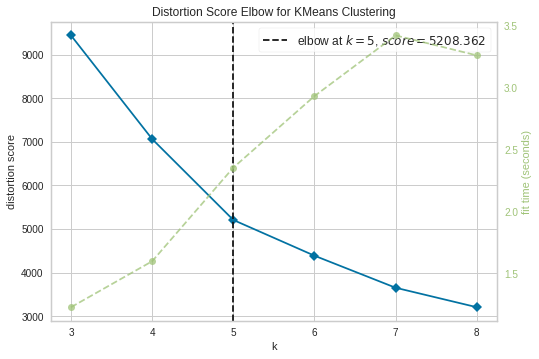

In [ ]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from yellowbrick.cluster import KElbowVisualizer

# set the numbers of components from Elbow Visiualizer method
components_num = 5 # PCA

# Generate synthetic dataset with 8 random clusters
X, y = make_blobs(n_samples=1000, n_features=12, centers=8, random_state=42)

# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,9))

visualizer.fit(scores[:,:components_num])        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

## Different performance metrics: PCA

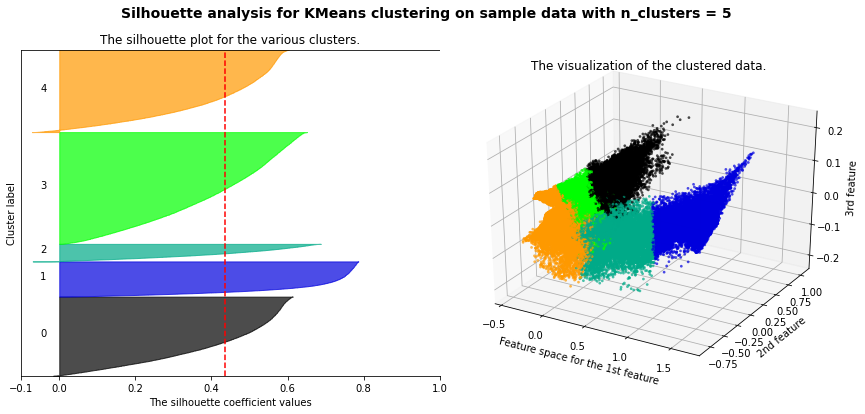

In [ ]:
selected_components = scores
# Calculate different performance metrics for various numbers of clusters
range_n_clusters = list(range(2,9))
columns = ['Number of clusters', 'Average Silhouette score', 'Calinski-Harabasz score', 'Davies-Bouldin score']
scores_pca = pd.DataFrame(np.zeros((len(range_n_clusters), len(columns))), columns=columns)

# 3D plots and different scores
for count, n_clusters in enumerate(range_n_clusters):
    # Create a subplot with 1 row and 2 columns
    fig = plt.figure(figsize=[15, 6])
    ax1 = fig.add_subplot(1, 2, 1)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(selected_components) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = cluster.KMeans(n_clusters=n_clusters, random_state=1)
    cluster_labels = clusterer.fit_predict(selected_components)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(selected_components, cluster_labels)
    
    scores_temp = [n_clusters, silhouette_avg,
                   # The resulting Calinski-Harabasz score.
                   calinski_harabasz_score(data_reshaped, clusterer.labels_),
                   # The resulting Davies-Bouldin score.
                   # The minimum score is zero, and the lower values the better clustering performance.
                   davies_bouldin_score(data_reshaped, clusterer.labels_)]
        
    scores_pca.iloc[[count]] = scores_temp

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(selected_components, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title('The silhouette plot for the various clusters.')
    ax1.set_xlabel('The silhouette coefficient values')
    ax1.set_ylabel('Cluster label')

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color='red', linestyle='--')

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        selected_components[:, 0], selected_components[:, 1], selected_components[:, 2],
        marker='.', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k'
    )

    ax2.set_title('The visualization of the clustered data.')
    ax2.set_xlabel('Feature space for the 1st feature')
    ax2.set_ylabel('2nd feature')
    ax2.set_zlabel('3rd feature')

    plt.suptitle(
        'Silhouette analysis for KMeans clustering on sample data with n_clusters = %d'
        % n_clusters,
        fontsize=14,
        fontweight='bold',
    )
    
    fig.subplots_adjust(wspace=0, hspace=0)
    print('finished one loop of visualization for PCA')

plt.show()

In [ ]:
from IPython.display import display, HTML
display(HTML(scores_pca.to_html(index=False)))

Number of clusters,Average Silhouette score,Calinski-Harabasz score,Davies-Bouldin score
5.0,0.434684,398748.675675,0.710592


# a. PCA -> K-means

applying the K-means on top of PCA

In [10]:
def plot_data(data,fig_name):
  fig = plt.figure(figsize = (15, 10))
  plt.imshow(data, cmap = 'nipy_spectral')
  plt.colorbar()
  plt.axis('off')
  plt.show()
  plt.savefig(fig_name)

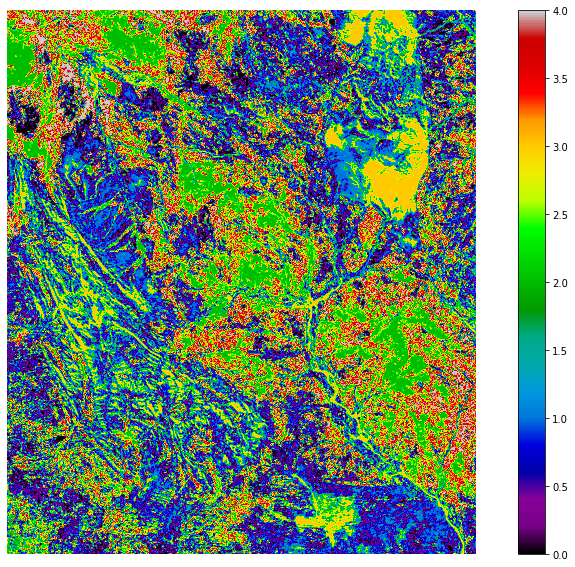

<Figure size 432x288 with 0 Axes>

In [11]:
# K-means
cl = cluster.KMeans(n_clusters=5) # Creating an object of the classifier
components_num = 5
param = cl.fit(scores[:,:components_num]) # Training
img_c = cl.labels_ # Getting the labels of the classes
img_cl = img_c.reshape(data_array[0,:,:].shape) # Reshaping the labels to a 3D array (single band)
plot_data(img_cl, 'PCA_k_means.png')

##2. Let’s set up  Auto-encoderE: 

###  Standardize Data:

the process of converting data to a common format to enable users to process and analyze it


In [12]:
sc = StandardScaler()
X_tr_std = sc.fit_transform(data_reshaped)

In [13]:
print(X_tr_std)
print(X_tr_std.shape)

[[-0.48631116 -0.77994569 -0.81380169 ...  0.24502926  0.23512374
   0.50316503]
 [ 0.02080077 -0.35623518 -0.29370282 ...  0.24502926  0.23512374
   0.50316503]
 [ 0.02080077  0.16108579  0.14210416 ...  0.83853292  0.64812145
   0.94404413]
 ...
 [-0.91703803 -0.41699987 -0.51250304 ... -0.62848639 -0.6160929
  -0.83068105]
 [-1.0549555  -0.65841632 -0.77075903 ... -0.62848639 -0.6160929
  -0.83068105]
 [-3.74116347 -3.79026106 -5.23822895 ... -6.87092747 -6.4169767
  -7.24210929]]
(12055050, 9)


In [14]:
# Encoder (input bands)10-10-10-10-9-8-7-6-5
encoder = keras.models.Sequential([
    keras.layers.Dense(10, input_shape=[10]),
    keras.layers.Dense(10, input_shape=[10]),
    keras.layers.Dense(10, input_shape=[10]),
    keras.layers.Dense(9, input_shape=[10]),
    keras.layers.Dense(8, input_shape=[9]),
    keras.layers.Dense(7, input_shape=[8]),
    keras.layers.Dense(6, input_shape=[7]),
    keras.layers.Dense(5, input_shape=[6]),
])

# Decoder 5-6-7-8-9-9-9-9-9 (output dimension/bands)
decoder = keras.models.Sequential([
    keras.layers.Dense(6, input_shape=[5]),
    keras.layers.Dense(7, input_shape=[6]),
    keras.layers.Dense(8, input_shape=[7]),
    keras.layers.Dense(9, input_shape=[8]),
    keras.layers.Dense(10, input_shape=[9]),
    keras.layers.Dense(10, input_shape=[10]),
    keras.layers.Dense(10, input_shape=[10]),
    keras.layers.Dense(10, input_shape=[10]),
])

# define the auto-encoder model
autoencoder = keras.models.Sequential([encoder, decoder])
autoencoder.compile(loss='mse', optimizer = keras.optimizers.SGD(learning_rate=0.01))

# epochs (hyperparameter)
epochs = 15

# saving the loss in history 
history = autoencoder.fit(X_tr_std,X_tr_std, epochs=epochs,
                         callbacks=[keras.callbacks.EarlyStopping(patience=10)])
# train the Auto-encoder model                        
codings = encoder.predict(X_tr_std)

376721/376721 [==============================] - 724s 2ms/step - loss: 0.0197


In [15]:
autoencoder.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 5)                 586       
                                                                 
 sequential_1 (Sequential)   (None, 9)                 590       
                                                                 
Total params: 1,176
Trainable params: 1,176
Non-trainable params: 0
_________________________________________________________________


In [16]:
# total learnable parameters
autoencoder.count_params()

1176

In [17]:
print(history.history.keys())

dict_keys(['loss'])


In [18]:
print(len(history.history['loss']))
train_loss_val = history.history['loss']
# test_loss_val = history.history['val_loss']
train_loss = [i * 1000 for i in train_loss_val]
# test_loss  = [i * 1000 for i in test_loss_val]

1


## Plot the train and validation loss for AE

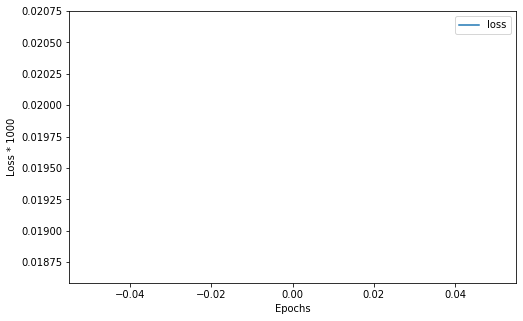

In [19]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.ylabel('Loss * 1000')
plt.xlabel('Epochs')
plt.savefig("summarize history for loss.jpg")

## Clustring using codings from AE

# a. AE -> K-means

applying the K-means on top of AE

In [ ]:
# K-means
cl = cluster.KMeans(n_clusters=5) # Creating an object of the classifier
# components_num = 5
param = cl.fit(codings) # codings from AE
img_c = cl.labels_ # Getting the labels of the classes
img_cl = img_c.reshape(data_array[0,:,:].shape) # Reshaping the labels to a 3D array (single band)
plot_data(img_cl, 'AE_k_means.png')

## Different performance metrics: AE

one loop completed for AE


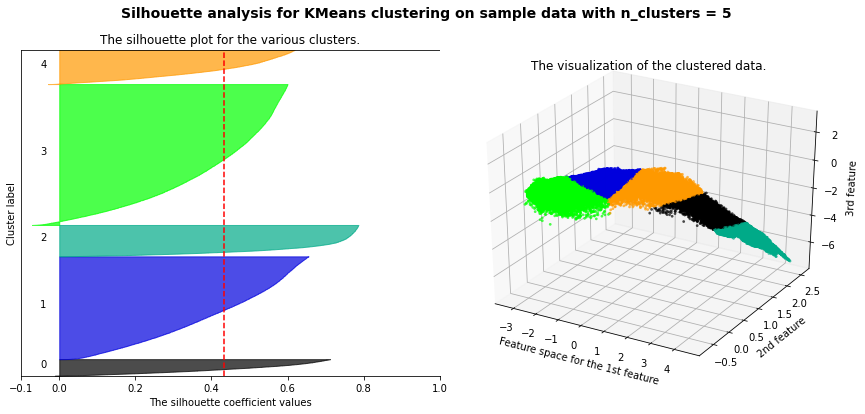

In [ ]:
# Calculate different performance metrics for various numbers of clusters
range_n_clusters = list(range(2,9))
columns = ['Number of clusters', 'Average Silhouette score', 'Calinski-Harabasz score', 'Davies-Bouldin score']
scores_ae = pd.DataFrame(np.zeros((len(range_n_clusters), len(columns))), columns=columns)

# 3D plots and different scores
# coding from the autoencoder

for count, n_clusters in enumerate(range_n_clusters):
    # Create a subplot with 1 row and 2 columns
    fig = plt.figure(figsize=[15, 6])
    ax1 = fig.add_subplot(1, 2, 1)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(codings) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = cluster.KMeans(n_clusters=n_clusters, random_state=1)
    cluster_labels = clusterer.fit_predict(codings)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(codings, cluster_labels)
    
    scores_temp = [n_clusters, silhouette_avg,
                   # The resulting Calinski-Harabasz score.
                   calinski_harabasz_score(data_reshaped, clusterer.labels_),
                   # The resulting Davies-Bouldin score.
                   # The minimum score is zero, and the lower values the better clustering performance.
                   davies_bouldin_score(data_reshaped, clusterer.labels_)]
    
    scores_ae.iloc[[count]] = scores_temp

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(codings, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title('The silhouette plot for the various clusters.')
    ax1.set_xlabel('The silhouette coefficient values')
    ax1.set_ylabel('Cluster label')

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color='red', linestyle='--')

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        codings[:, 0], codings[:, 1], codings[:, 2],
        marker='.', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k'
    )

    ax2.set_title('The visualization of the clustered data.')
    ax2.set_xlabel('Feature space for the 1st feature')
    ax2.set_ylabel('2nd feature')
    ax2.set_zlabel('3rd feature')

    plt.suptitle(
        'Silhouette analysis for KMeans clustering on sample data with n_clusters = %d'
        % n_clusters,
        fontsize=14,
        fontweight='bold',
    )
    print('one loop completed for AE')
    fig.subplots_adjust(wspace=0, hspace=0)

plt.show()

In [ ]:
from IPython.display import display, HTML
display(HTML(scores_ae.to_html(index=False)))

Number of clusters,Average Silhouette score,Calinski-Harabasz score,Davies-Bouldin score
5.0,0.432286,304397.37828,0.830652


# 3. Stacked AE

## NonLinear Stacked Encoder-Decoder
The nonlinear stacked AE will be easily implemented as the stacked AE but with an activation function. We also introduced a decay constant over the SGD optimizer so that the learning rate will decrease over time. We pick “selu” as activation layer for all layers. Note that here we have increased the complexity even more: we could try to find the best number of hidden layers, the best activation function and shape of each of the layers for the specific problem.

In [21]:
nl_st_encoder = keras.models.Sequential([
    keras.layers.Dense(9, input_shape=[10], activation='relu'),
    keras.layers.Dense(8, activation='selu'),
    keras.layers.Dense(7, activation='selu'),
    keras.layers.Dense(6, activation='selu'),
    keras.layers.Dense(5, activation='selu'),
    keras.layers.Dense(5, activation='selu'),
])

nl_st_decoder = keras.models.Sequential([
    keras.layers.Dense(5, input_shape=[5], activation='selu'),
    keras.layers.Dense(6, activation='relu'),
    keras.layers.Dense(7, activation='relu'),
    keras.layers.Dense(8, activation='relu'),
    keras.layers.Dense(9, activation='relu'),
    keras.layers.Dense(10, activation='relu'),


])

nl_st_autoencoder = keras.models.Sequential([nl_st_encoder, nl_st_decoder])
nl_st_autoencoder.compile(loss='mse', optimizer = keras.optimizers.SGD(learning_rate=0.01, decay=1e-4))
nl_st_autoencoder.summary()


history = nl_st_autoencoder.fit(X_tr_std,X_tr_std, epochs=epochs,
                         callbacks=[keras.callbacks.EarlyStopping(patience=10)],verbose=1)

nl_st_codings_train = nl_st_encoder.predict(X_tr_std)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 5)                 256       
                                                                 
 sequential_4 (Sequential)   (None, 9)                 260       
                                                                 
Total params: 516
Trainable params: 516
Non-trainable params: 0
_________________________________________________________________
376721/376721 [==============================] - 689s 2ms/step - loss: 0.6624


In [22]:
nl_st_autoencoder.count_params()

516

In [23]:
print(history.history.keys())
print(len(history.history['loss']))
train_loss_val = history.history['loss']
# test_loss_val = history.history['val_loss']
train_loss = [i * 1000 for i in train_loss_val]
# test_loss  = [i * 1000 for i in test_loss_val]

dict_keys(['loss'])
1


## Plot the train and validation loss for Stacked-AE

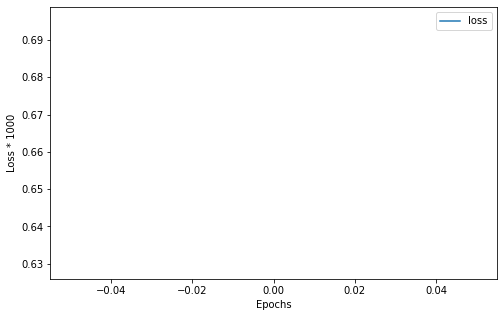

In [24]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.ylabel('Loss * 1000')
plt.xlabel('Epochs')
plt.savefig("summarize history for loss.jpg")

## Clustring using codings from Stacked-AE





# a. Stacked-AE -> K-means

applying the K-means on top of AE

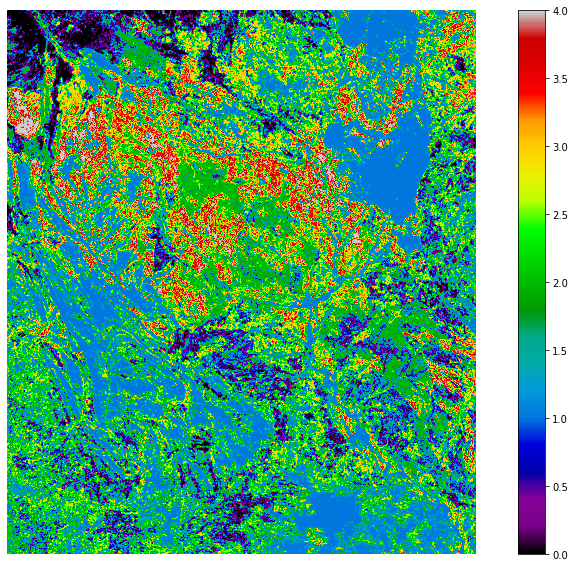

<Figure size 432x288 with 0 Axes>

In [25]:
# K-means
cl = cluster.KMeans(n_clusters=5) # Creating an object of the classifier
# components_num = 5
param = cl.fit(nl_st_codings_train) # codings from AE
img_c = cl.labels_ # Getting the labels of the classes
img_cl = img_c.reshape(data_array[0,:,:].shape) # Reshaping the labels to a 3D array (single band)
plot_data(img_cl, 'stacked_AE_k_means.png')

## Different performance metrics: Stacked-AE

one loop completed for stacked-AE


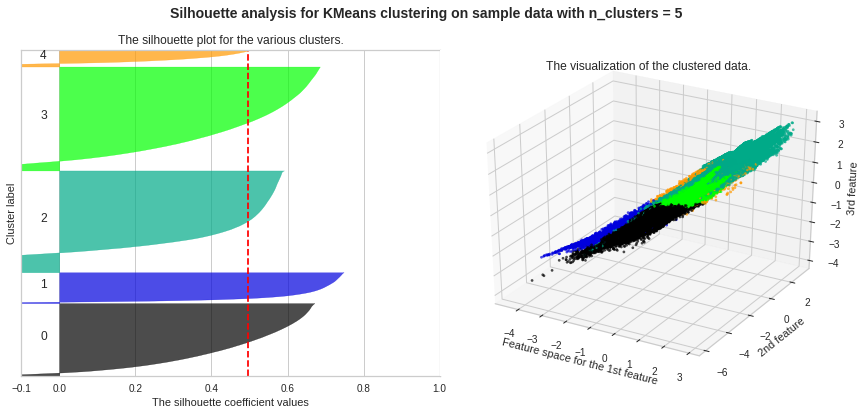

In [ ]:
# Calculate different performance metrics for various numbers of clusters
range_n_clusters = list(range(2,9))
columns = ['Number of clusters', 'Average Silhouette score', 'Calinski-Harabasz score', 'Davies-Bouldin score']
scores_stacked_ae = pd.DataFrame(np.zeros((len(range_n_clusters), len(columns))), columns=columns)

# 3D plots and different scores
# coding from the autoencoder

for count, n_clusters in enumerate(range_n_clusters):
    # Create a subplot with 1 row and 2 columns
    fig = plt.figure(figsize=[15, 6])
    ax1 = fig.add_subplot(1, 2, 1)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(nl_st_codings_train) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = cluster.KMeans(n_clusters=n_clusters, random_state=1)
    cluster_labels = clusterer.fit_predict(nl_st_codings_train)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(nl_st_codings_train, cluster_labels)
    
    scores_temp = [n_clusters, silhouette_avg,
                   # The resulting Calinski-Harabasz score.
                   calinski_harabasz_score(data_reshaped, clusterer.labels_),
                   # The resulting Davies-Bouldin score.
                   # The minimum score is zero, and the lower values the better clustering performance.
                   davies_bouldin_score(data_reshaped, clusterer.labels_)]
    
    scores_stacked_ae.iloc[[count]] = scores_temp

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(codings, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title('The silhouette plot for the various clusters.')
    ax1.set_xlabel('The silhouette coefficient values')
    ax1.set_ylabel('Cluster label')

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color='red', linestyle='--')

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        codings[:, 0], codings[:, 1], codings[:, 2],
        marker='.', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k'
    )

    ax2.set_title('The visualization of the clustered data.')
    ax2.set_xlabel('Feature space for the 1st feature')
    ax2.set_ylabel('2nd feature')
    ax2.set_zlabel('3rd feature')

    plt.suptitle(
        'Silhouette analysis for KMeans clustering on sample data with n_clusters = %d'
        % n_clusters,
        fontsize=14,
        fontweight='bold',
    )
    print('one loop completed for stacked-AE')
    fig.subplots_adjust(wspace=0, hspace=0)

plt.show()

In [ ]:
from IPython.display import display, HTML
display(HTML(scores_stacked_ae.to_html(index=False)))

Number of clusters,Average Silhouette score,Calinski-Harabasz score,Davies-Bouldin score
5.0,0.495336,345080.835828,0.753461
